# Cluster Mapping Walkthrough

The objective of this notebook it to walk the reader through the code that is intended to serve as a proof of concept for mapping disinformation. One of the major underlying assumption behind this proof of concept is that individual pieces of disinformation can be flagged by machine learning models. Obviously, no model is perfect, but a large body of work exists suggesting that flagging disinformation can be achieved to a certain extent. 

In this particular proof of concept, headlines from sources determined by https://mediabiasfactcheck.com/ to be generally "conspiracy" or "fake-news" serve as the text corpus in the interest of understandability. Clearly, all of the content won't be considered disinformation, but the general concept of mapping emerging themes is the main focus. 

With the general introduction out of the way, the following code will utilize the various python packages imported below. Additionally, some of the main functions of those packages and other general aspects are instantiated. When certain packages are used further along in the code, more commentary will be made.

In [1]:
from nltk.stem import WordNetLemmatizer
from flair.models import MultiTagger
from flair.data import Sentence
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow_hub as hub
import umap.umap_ as umap
import seaborn as sns
import pandas as pd
import numpy as np

import math
import yake
import gdeltdoc
import hdbscan
import re

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 5, 'linewidths':0}

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
tagger = MultiTagger.load(["pos-fast", "ner-fast"])
lemmatizer = WordNetLemmatizer()

2022-05-01 18:59:39,871 --------------------------------------------------------------------------------
2022-05-01 18:59:39,872 The model key 'pos-fast' now maps to 'https://huggingface.co/flair/pos-english-fast' on the HuggingFace ModelHub
2022-05-01 18:59:39,873  - The most current version of the model is automatically downloaded from there.
2022-05-01 18:59:39,873  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/pos-fast/en-pos-ontonotes-fast-v0.5.pt)
2022-05-01 18:59:39,874 --------------------------------------------------------------------------------
2022-05-01 18:59:40,420 loading file /Users/peter/.flair/models/pos-english-fast/36f7923039eed4c66e4275927daaff6cd275997d61d238355fb1fe0338fe10a1.ff87e5b4e47fdb42a0c00237d9506c671db773e0a7932179ace82e584383a1b8
2022-05-01 18:59:40,868 --------------------------------------------------------------------------------
2022-05-01 18:59:40,869 The model key 'ner-fast' 

## Regex Text Cleaning

This function is a basic function that uses regex to clean the headline text

In [2]:
def clean_title(string):
    string = re.sub("--.*", "", string)
    string = re.sub("^(\w+ \|)", "", string)
    string = re.sub("(- \w*)$", "", string)
    string = re.sub("\<.*?\>", "", string)
    string = re.sub("\A[ ]{1,100}", "", string)
    string = re.sub("[ ]{1,10}", " ", string)
    string = re.sub("(\d) : ([\d]{1,2}) ([aApP]{1,2}) \. ([mM]{1,2}) \.", "\\1:\\2 \\3.\\4.", string)
    string = re.sub("(\d) %", "\\1%", string)
    string = re.sub("([a-zA-Z]) , ([a-zA-Z])", "\\1, \\2", string)
    string = re.sub("(\w) ; (\w)", "\\1; \\2", string)
    string = re.sub("(\w) : (\w)", "\\1: \\2", string)
    string = re.sub("(\d): (\d)", "\\1:\\2", string)
    string = string = re.sub("(\d) , (\d)", "\\1,\\2", string)
    string = re.sub("([a-zA-Z]) \. ([a-zA-Z])", "\\1. \\2", string)
    string = re.sub(" \.\.\.", "...", string)
    string = re.sub("(\d) / (\d) / (\d)", "\\1/\\2/\\3", string)
    string = re.sub(" - ", "-", string)
    string = re.sub("(\d) \. (\d)", "\\1.\\2", string)
    string = re.sub("(.*) \.", "\\1.", string)
    string = re.sub("(.*)[ ]$", "\\1", string)
    string = re.sub("(\w) \?", "\\1?", string)
    return string

## Data Import

In this cell, headlines that were collected from https://www.gdeltproject.org/ are used to form the foundation of the emerging themes of disinformation. This activity could be performed on a daily, weekly, or monthly basis. Since disinformation is perpetually evolving, this process allows the detection of new emerging themes. After the foundation is built, themes that are determined important by analysts can be tracked.

In this particular code, the data collected spans from roughly February 1, 2022 to April 1, 2022. Because of this, a subset of the dataset needs to be taken to replicate what would happen during potential real world application of this process.

In [3]:
feb_1_ts = datetime.timestamp(datetime.strptime("02-01-2022", "%m-%d-%Y"))
mar_1_ts = datetime.timestamp(datetime.strptime("03-01-2022", "%m-%d-%Y"))
base_data = pd.read_csv("GDELT-Cluster-Analysis-Unique.csv")
base_data = base_data[base_data['sourcecountry'] == "United States"]
base_data["title"] = base_data["title"].map(lambda x: clean_title(x))
base_data["seendate"] = base_data["seendate"].map(lambda x: datetime.timestamp(datetime.strptime(x, "%Y%m%dT%H%M%SZ")))
base_data = base_data.sort_values(by="seendate").reset_index(drop=True)
build_data = base_data[base_data["seendate"] < mar_1_ts]
build_data = build_data[build_data["seendate"] >= feb_1_ts]

## Encoding

In this cell, the headlines are encoded into numerical vectors. Two python packages are used to accomplish this task. The first python package is the TensorFlow package that is utilizing the deep averaging network (DAN) Universal Sentence Encoder Version 4 (https://tfhub.dev/google/universal-sentence-encoder/4). This is a subset of deep learning, and additional reading on this process can be found here: https://amitness.com/2020/06/universal-sentence-encoder/. The output of this package is a 512 dimension vector serving as a numerical representation of the headline. 

The second python package is the Uniform Manifold Approximation and Projection (UMAP) package. The main takeway from this package is that the 512 dimension vector is approximated into a 2 dimension vector. The reason that this is done is because the clustering package that will be used in the upcomming cells operates more effeciently and without much loss of utility with 2 dimensional vectors. Additionally, the ability to visualize clustering is much easier in 2 dimensions. For further reading on this process and package: https://umap-learn.readthedocs.io/en/latest/

In [4]:
embeddings = embed(list(build_data["title"].dropna()))
reducer = umap.UMAP(random_state=42)
reducer.fit(embeddings)
reduced_embeddings = reducer.transform(embeddings)

## Clustering

In this cell, the encodings of the headlines are clustered using the HDBscan package. First, general clusters or themes are surfaced and for a detailed walkthrough of this process: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html. Then, after the clustering is complete, a visualization is generated of the clusters. Due to the limited number of color palettes, some of the colors are repeated for different clusters. However, the general clusters can be seen relatively easily.

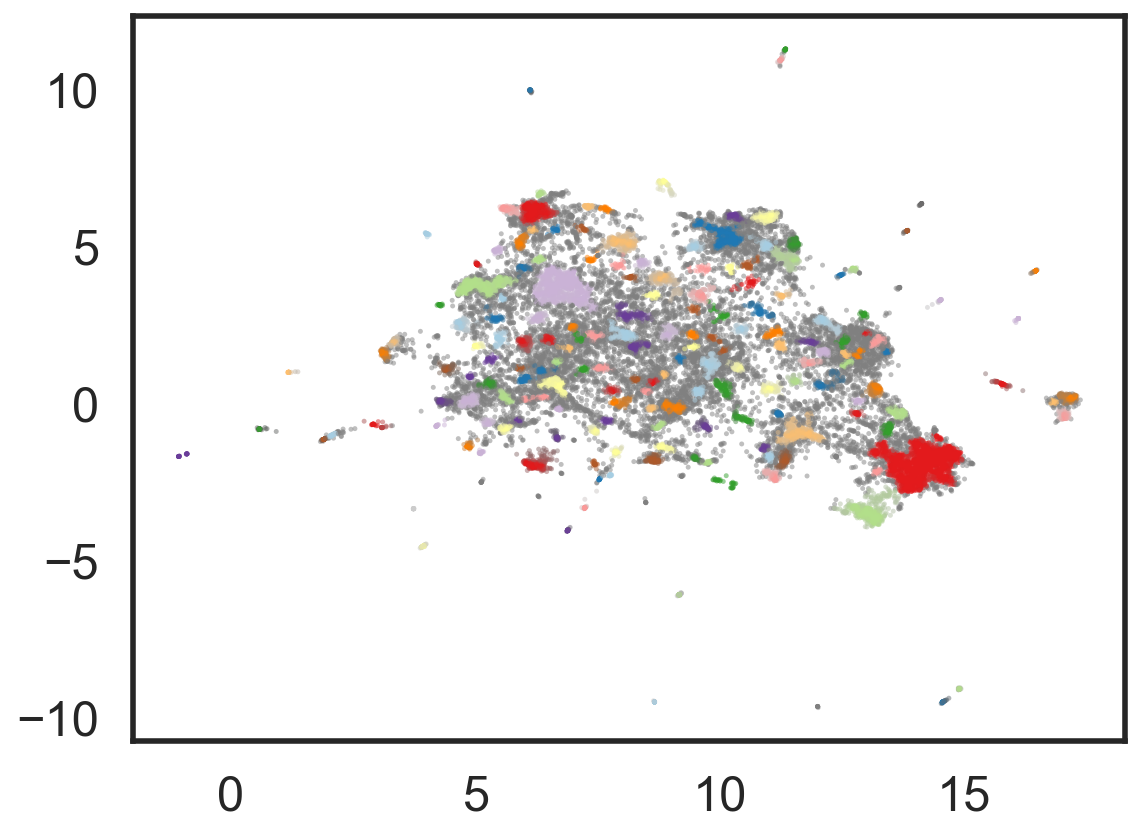

In [5]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True).fit(reduced_embeddings)

plt.figure(figsize=(8, 6), dpi=160)
palette = sns.color_palette("Paired", 1800)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=cluster_colors, **plot_kwds)

## Soft Clustering

In the visualization above, it is apparent that a large amount of the points, which represent different headlines are gray. This represents what the clustering algorithm has determined to be noise, or not belonging to a cluster. For the purpose of this process, this is not effective. To account for this, soft clustering has been employed. Essentially, each headline is assigned a probability vector of what cluster it belongs to. Then, the cluster that the headline is most likely to be a part of is chosen to be the cluster of the headline. Then, a visualization of this soft clustering is provided below. For further reading about the soft clustering process: https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html

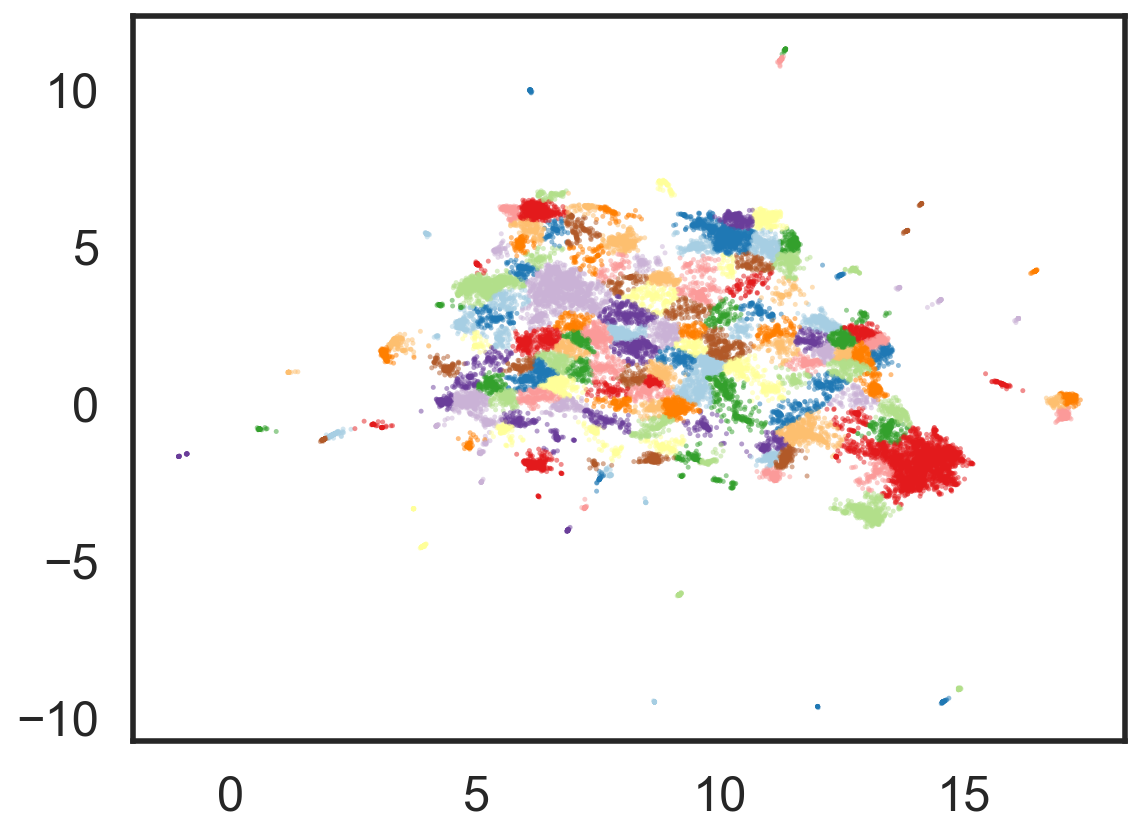

In [6]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

plt.figure(figsize=(8, 6), dpi=160)
color_palette = sns.color_palette("Paired", 1800)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=cluster_colors, **plot_kwds)

## Cluster Sorting

After the cluster foundations have been established, analysis can begin regarding which clusters to address. The code below groups the textual data according to the clusters, measures the size of the cluster, and determines the relative center of the cluster.

To determine the center of the cluster, the mean of the coordinates of each cluster is calculated. This center will then be used to track the evolution of the cluster be assigning new individual headlines to the cluster with a center that is closest to the individual headline. Additionally, a visualization of the centers has been provided, with a star representing the center.

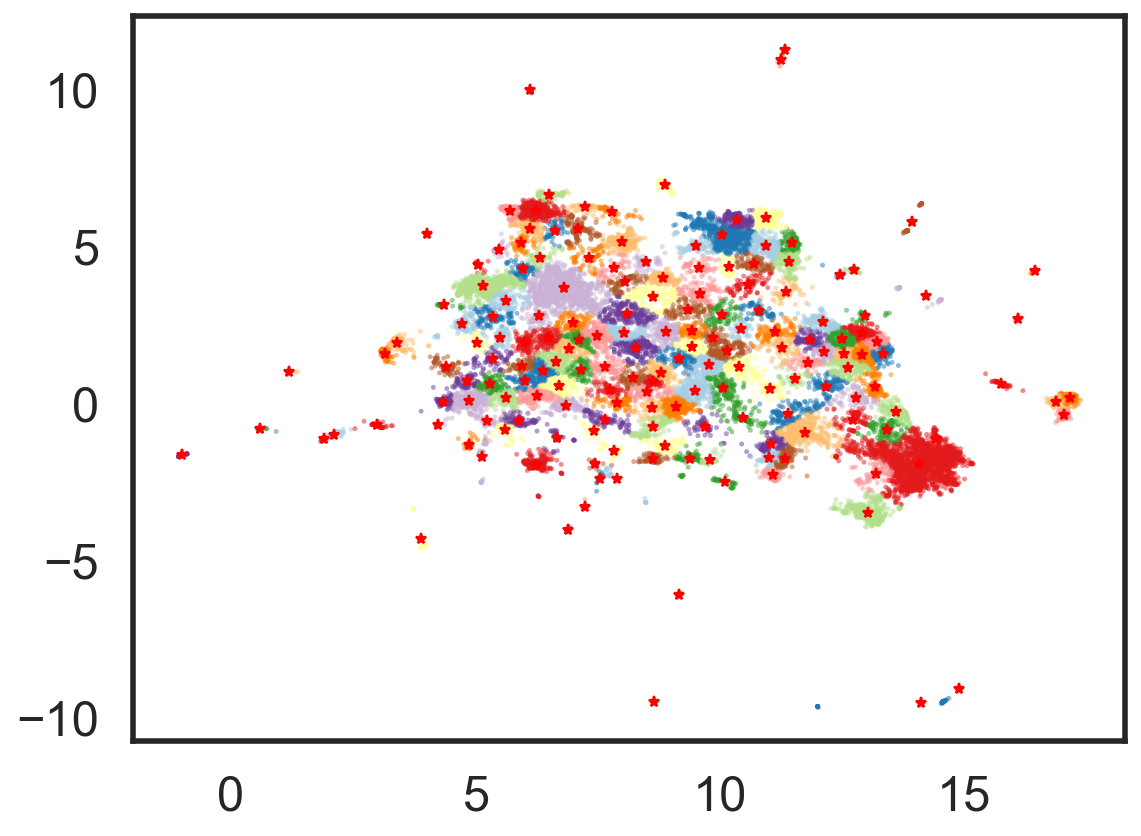

In [7]:
soft_cluster_indexes = [[] for i in range(0,len(soft_clusters[0]))]
soft_cluster_sizes = dict.fromkeys([i for i in range(0,len(soft_clusters[0]))],0)
soft_cluster_centers = [[0,0] for i in range(0,len(soft_clusters[0]))]
for soft_cluster in enumerate(soft_clusters):
    index = np.argmax(soft_cluster[1])
    soft_cluster_indexes[index].append(soft_cluster[0])
    soft_cluster_sizes[index] += 1
    soft_cluster_centers[index][0] += reduced_embeddings[soft_cluster[0]][0]
    soft_cluster_centers[index][1] += reduced_embeddings[soft_cluster[0]][1]
for soft_cluster_center in enumerate(soft_cluster_centers):
    soft_cluster_center[1][0] = soft_cluster_center[1][0] / soft_cluster_sizes[soft_cluster_center[0]]
    soft_cluster_center[1][1] = soft_cluster_center[1][1] / soft_cluster_sizes[soft_cluster_center[0]]
sorted_soft_cluster_sizes = sorted(soft_cluster_sizes.items(), key=lambda kv: kv[1], reverse = True)

plt.figure(figsize=(8, 6), dpi=160)
palette = sns.color_palette("Paired", 1800)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=cluster_colors, **plot_kwds)
plt.plot([i[0] for i in soft_cluster_centers], [i[1] for i in soft_cluster_centers], marker='*', ls='none', ms=5, c="red")

## Individual Cluster

Now that the size of the clusters have been determined, the biggest cluster will be examined. Below is a printout of the headlines in that cluster. While it is not exact, clearly the Russia-Ukraine conflict is the theme.

In [8]:
for index in soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]:
    print(build_data.iloc[index]["title"])

US Charged With Trying To Provoke Russian Military Action At UN: You Want It To Happen
US Sanctions Would Include Action Against Moscow Elites If Russia Invades Ukraine: White House
The Crisis in Ukraine: Are We Still the Good Guys?
U. S. and allies debate the intelligence on how quickly Putin will order an invasion of Ukraine or whether he will at all
Moscow to Washington: Remove the Nukes on Our Doorstep and Stop the Eastward Push
Ukraine planning false flag Donbass incident-militia
Hungary PM Orbán to visit Putin in Moscow to discuss gas, vaccines, nuclear power
Venezuelan Ex General Says CIA Knew of Plots Against Maduro
13,420 Russians Crossed Illegally in 2021 But As Long As It Not Ukraine Border
Germany SPD Seeks to Present Unified Face Amid Criticism Over Muted Response to Russia
Russian Navy Holds Anti-Submarine Drills Near NATO Country, Prepares For More
Mark Levin: Why America isnt ready for war with China and Russia
The Globalist Reset Agenda Has Failed – Is Ukraine Plan B?


The View host Joy Behar worries war in Ukraine could spoil her European vacation
Global chess body cancels big events in Russia over invasion
NATO vows to protect its territory after Russian attack on Ukraine
Russia accuses US of developing bioweapons near its borders
Putin threatens bloodbath if country resists Russian forces as troops near Kiev
Germany halts Nord Stream 2 pipeline project with Russia over Ukraine incursion, putting citizens at risk of freezing
China Urges Putin to Negotiate With Ukraine While Continuing to Reject Invasion Label
The West Could Have Prevented The Russo-Ukrainian War, But Didnt
Ukraine Claims It Has Killed Nearly 3,000 Russian Troops
Russian Invasion of Ukraine Is a Boon for the Chinese Regime
Putin calls on Ukraine army to remove leadership in Kyiv
Twitter Says It Will Consider Censoring Emerging Narratives About Ukraine War
Updated-Final words of 13 Ukrainian island border guards to Russians Go f * ck yourself !
During call with Putin Iran President s

## Cluster Daily Growth

Then, the number of headlines in this cluster that were published can be tallied. First, a general bar chart with the number of headlines on each day reveals that there was a pretty steady publishing and then a relativle explosion around 02-02-2022.

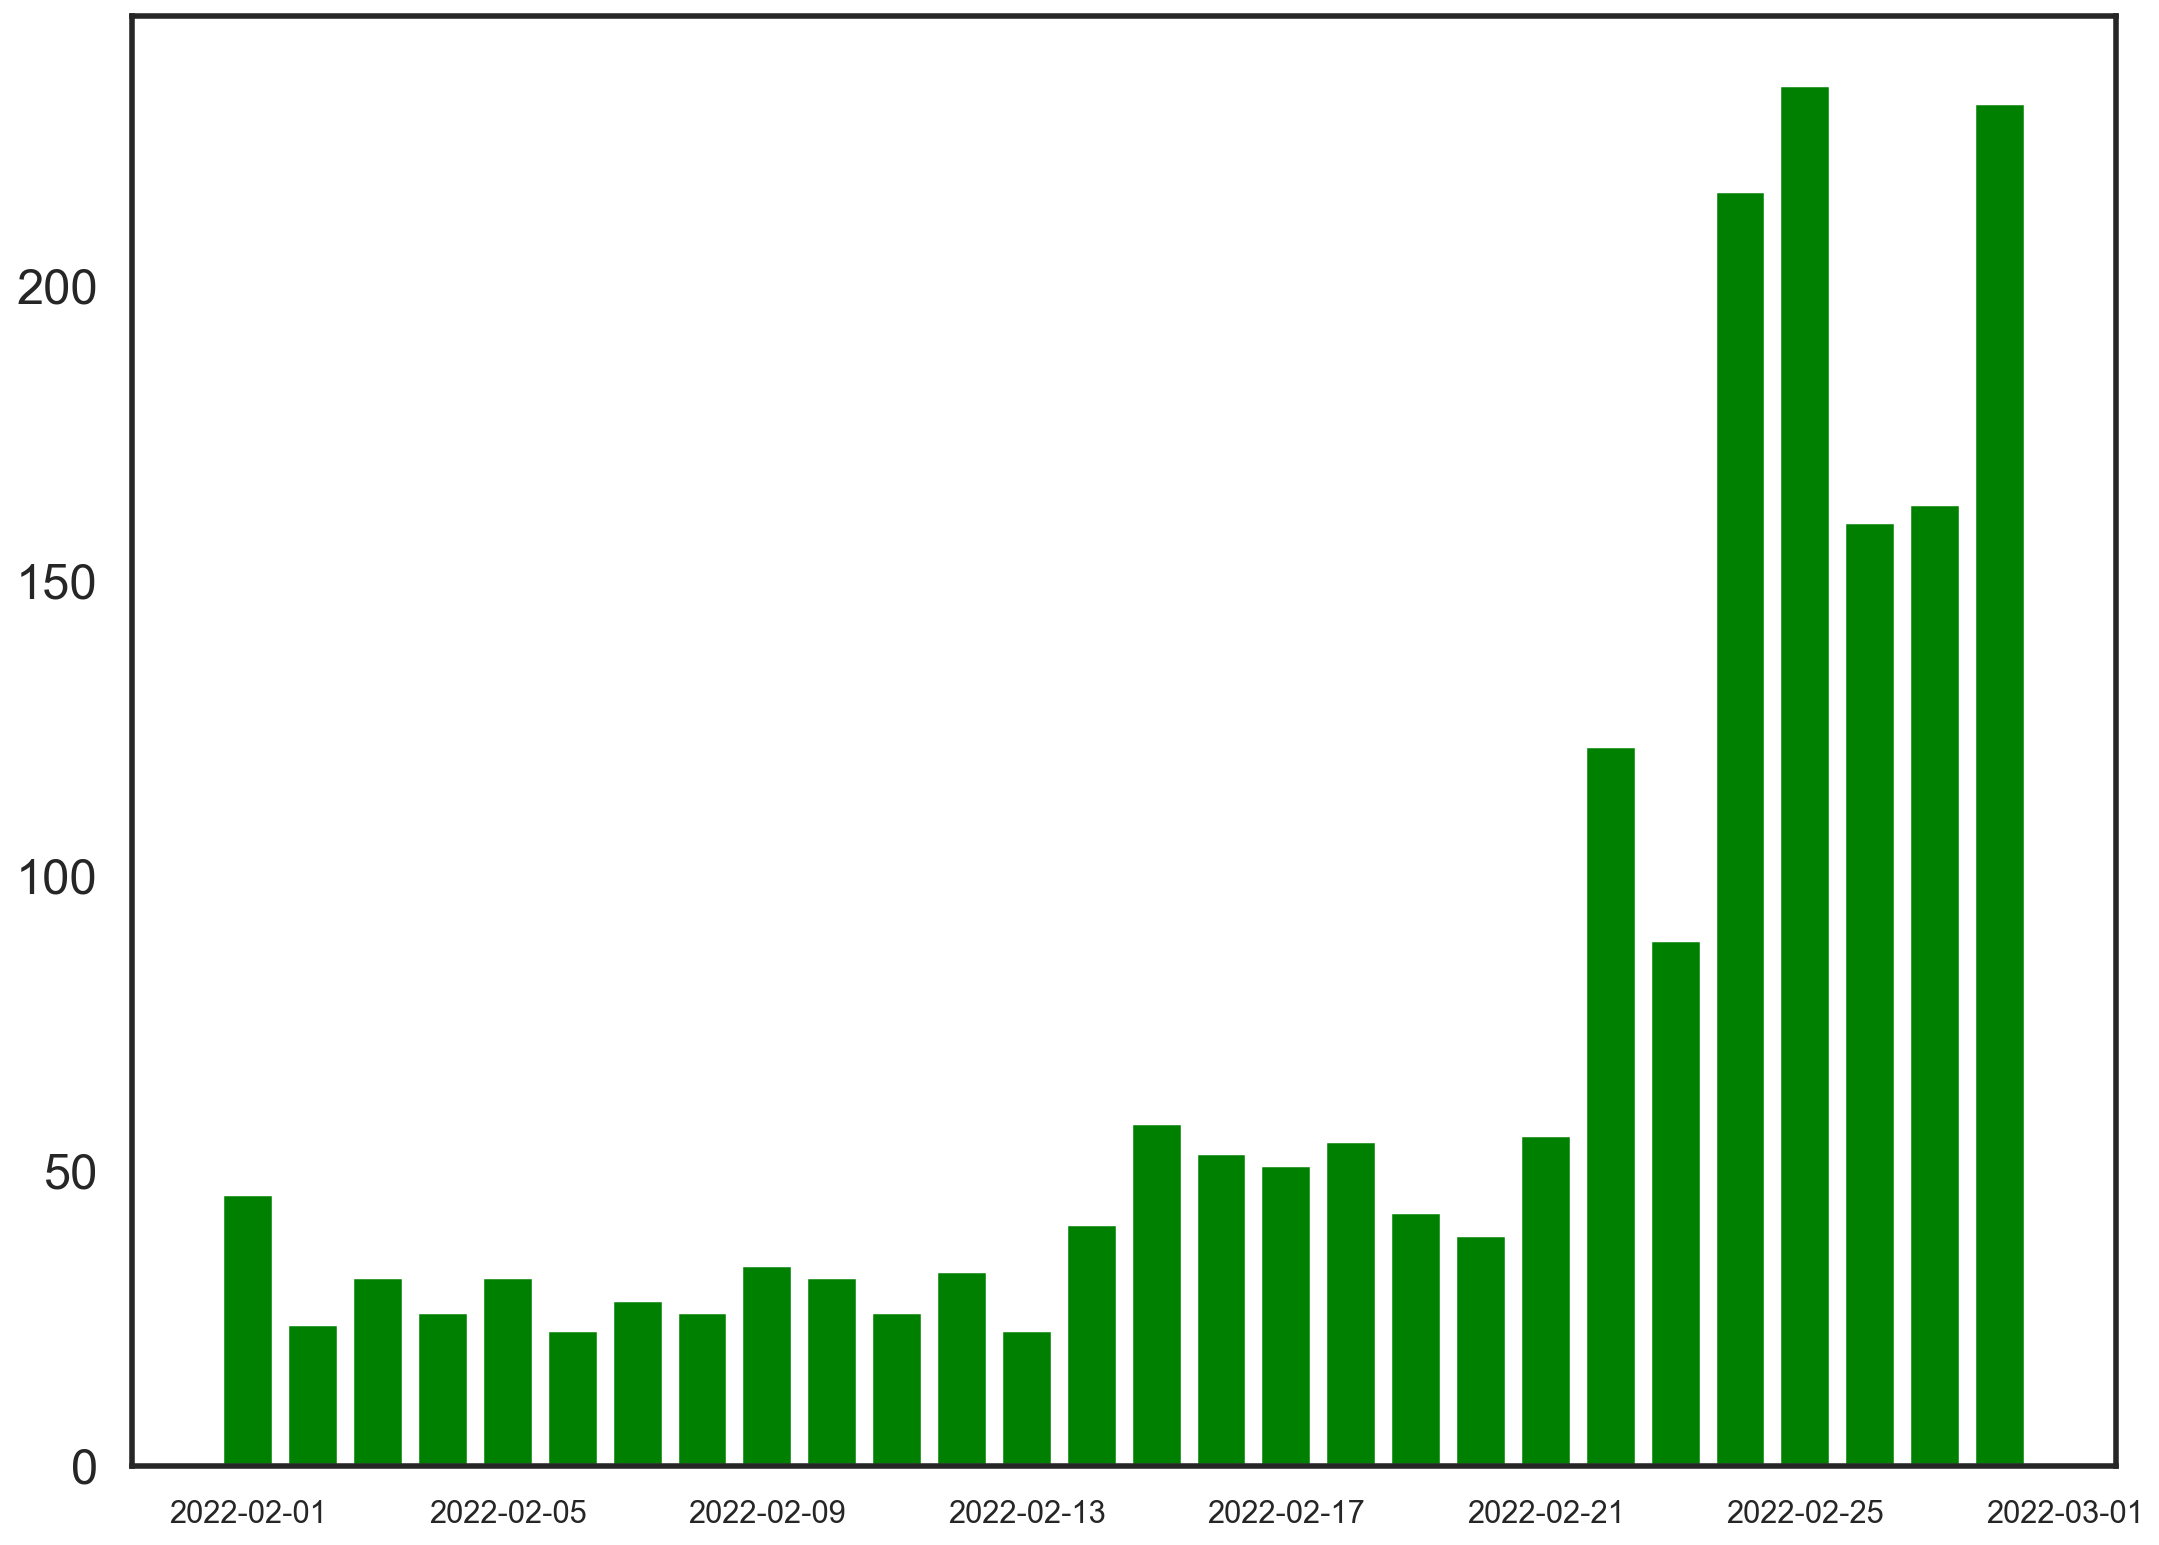

In [9]:
dates = [datetime.fromtimestamp(timestamp).strftime('%d-%m-%y') for timestamp in list(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["seendate"])]
date_counts = [0 for date in range(0,len(np.unique(dates)))]
index = 0
day = dates[0]
for date in dates:
    if date != day:
        index += 1
        day = date
    date_counts[index] += 1
    
plt.figure(figsize=(16, 12), dpi=160)
plt.bar(sorted([datetime.strptime(i, '%d-%m-%y') for i in np.unique(dates)]), date_counts, color='green')
plt.xticks(size="xx-small")
plt.show()

## Cluster Week-on-Week Average Growth

In addition to the daily growth bar chart, a measuring the growth of the average of the trailing week versus the average of the week prior to that can be a helpful visualization.

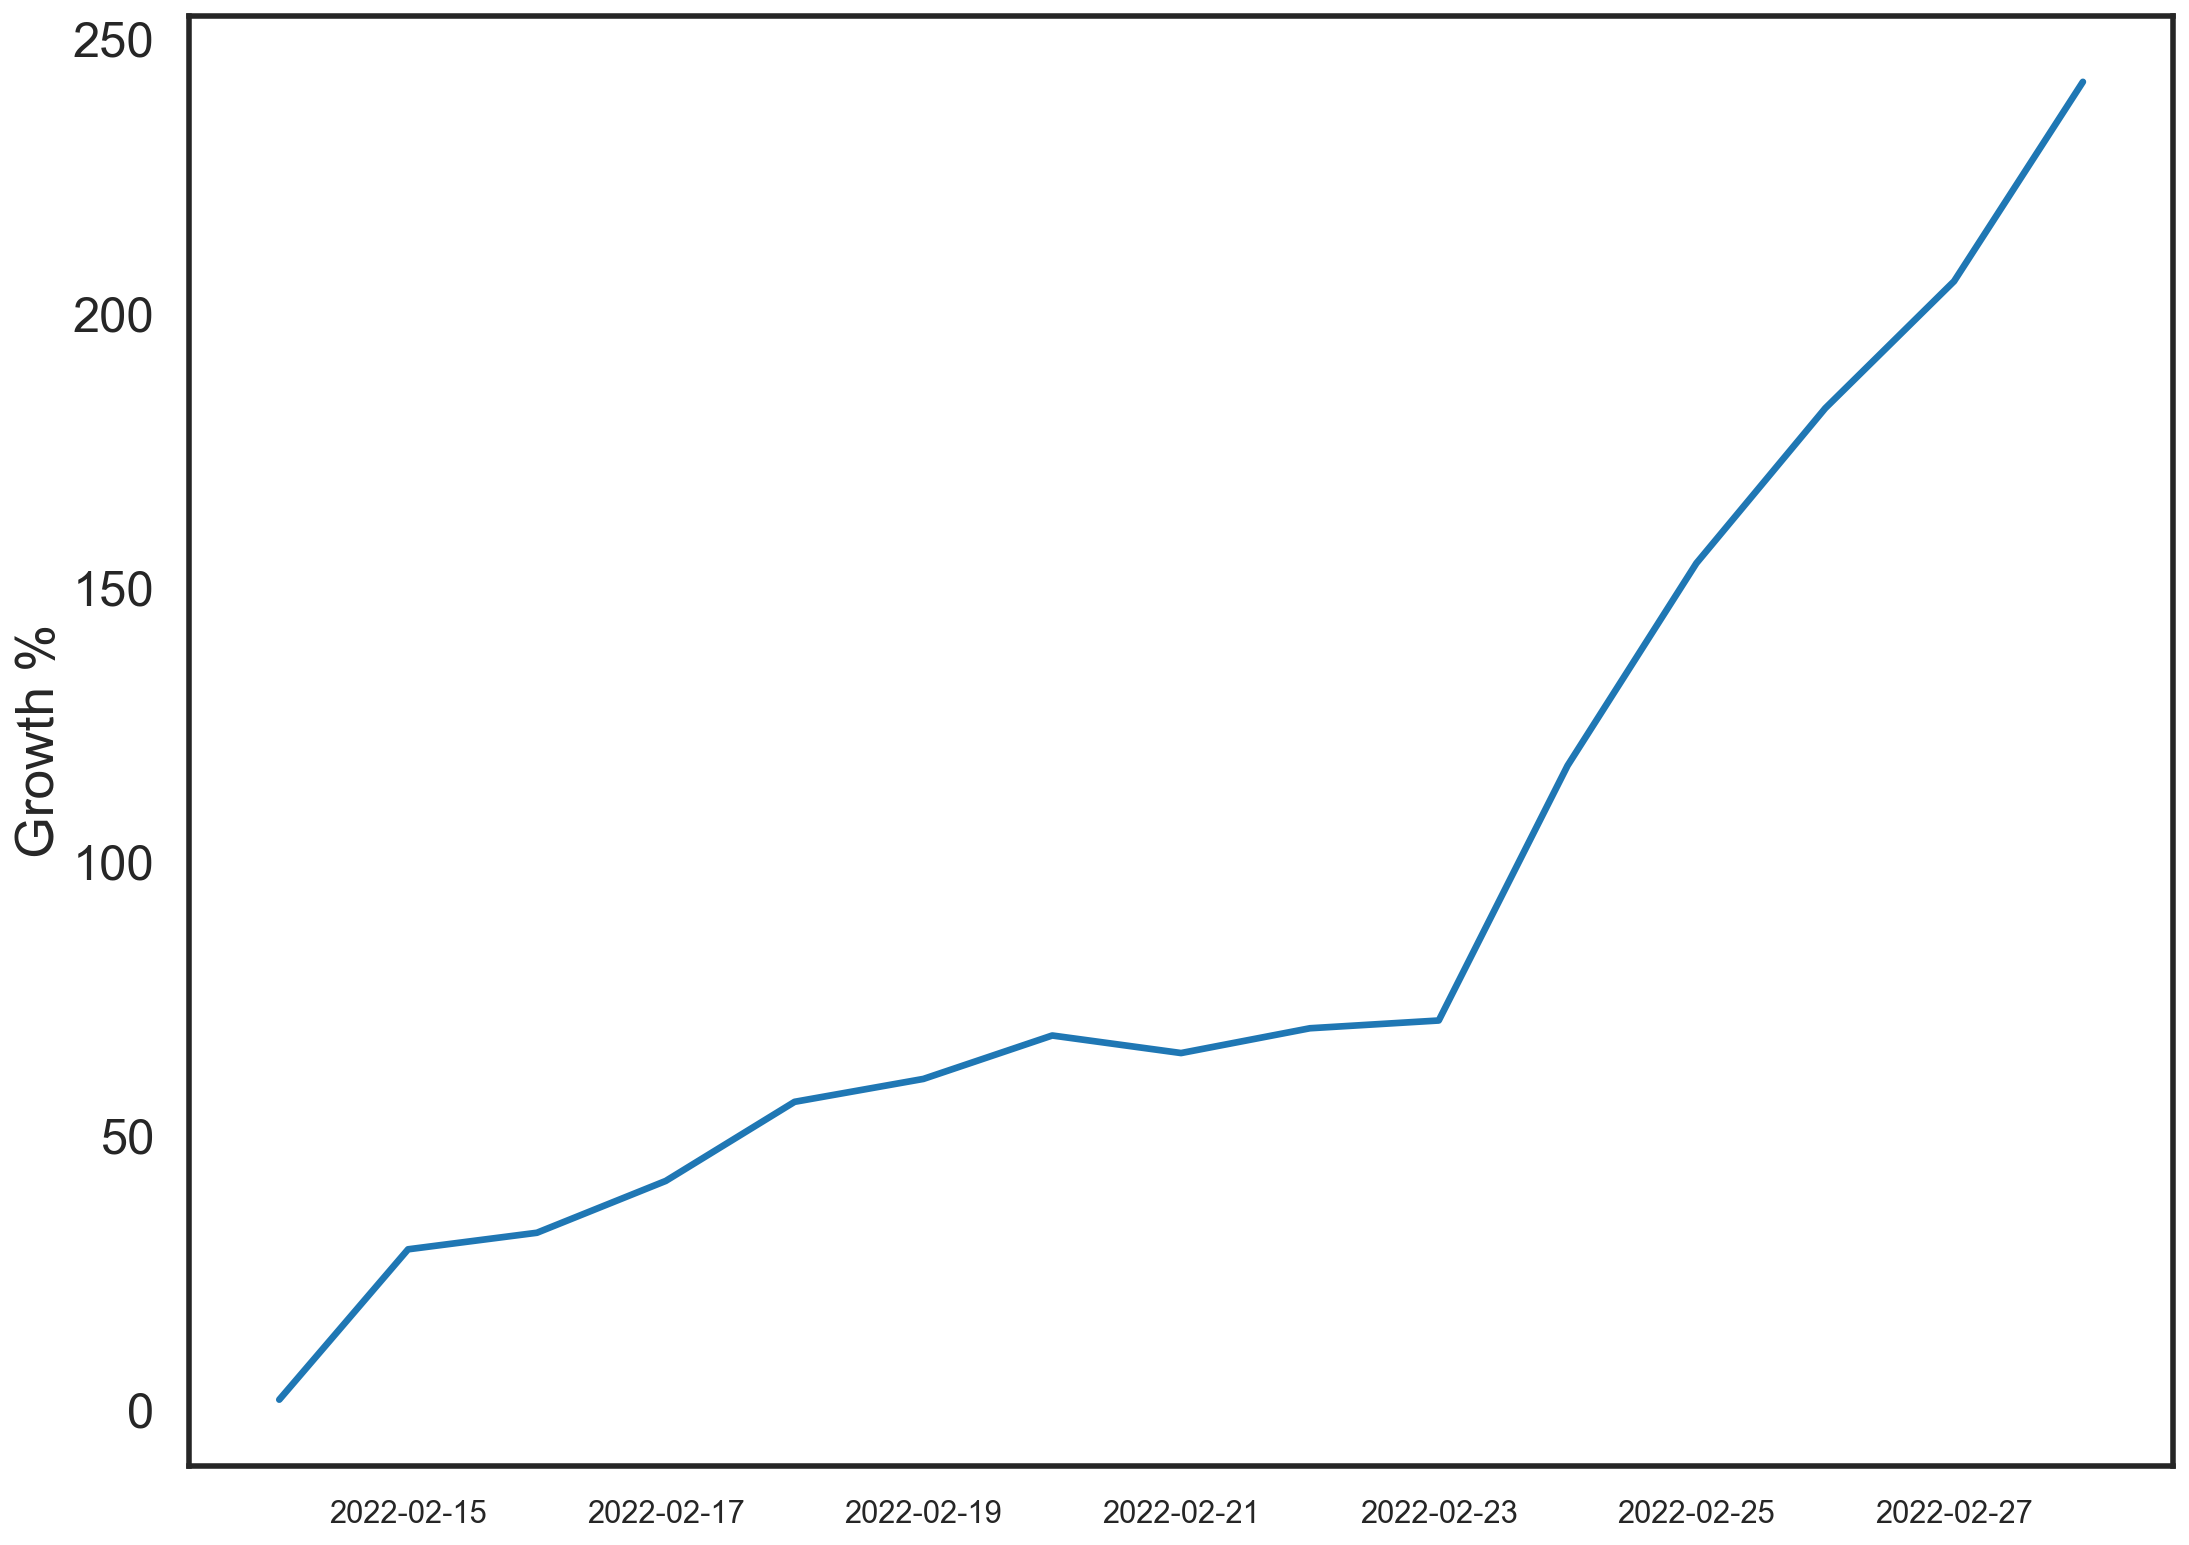

In [10]:
date_wow_growth = [0 for i in range(0,len(date_counts[13:]))]
for date in enumerate(date_wow_growth):
    trailing_avg = np.mean(date_counts[date[0] + 7:date[0] + 14])
    previous_avg = np.mean(date_counts[date[0]: date[0] + 7])
    change = (trailing_avg - previous_avg) / previous_avg
    date_wow_growth[date[0]] = change * 100
    
plt.figure(figsize=(16, 12), dpi=160)
plt.plot(sorted([datetime.strptime(i, '%d-%m-%y') for i in np.unique(dates)])[13:], date_wow_growth)
plt.xticks(size="xx-small")
plt.ylabel("Growth %")
plt.show()

## Domain Word Clouds

Another helpful tool can be be a word cloud showing the frequency of sources. In this example, domains are the best way to do this, but platforms or usernames and such could aslo be used. Additionally, this information could be combined with site traffic data from sources like Google Analytics or other social media metrics to estimate the exposure of the cluster to the public. 

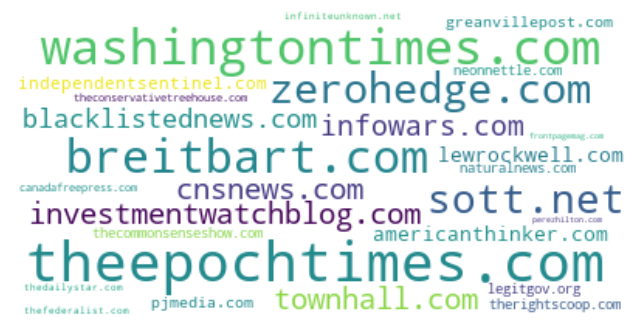

In [11]:
cluster_0_domains = list(set(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["domain"]))
cluster_0_dict = {}

for domain in cluster_0_domains:
    cluster_0_dict[domain] = 0
    for i in list(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["domain"]):
        if domain == i:
            cluster_0_dict[domain] += 1
            
wordcloud = WordCloud(background_color="white").fit_words(cluster_0_dict)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Part of Speech Word Clouds

Another potentially useful visualization are part of speech word cloud. Below, word cloud for verbs is generated for the cluster. This is using the flairNLP package to tag the POS of each sentence, and then creating dictionaries for with keys based on the different parts of speech. 

In [13]:
cluster_0_string = " ".join(list(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["title"]))
cluster_0_sentence = Sentence(cluster_0_string)
tagger.predict(cluster_0_sentence)
cluster_0_word_dict = {}
for i in cluster_0_sentence.get_spans():
    if i.tag in cluster_0_word_dict.keys():
        cluster_0_word_dict[i.tag].append(i.text)
    else:
        cluster_0_word_dict[i.tag] = [i.text]

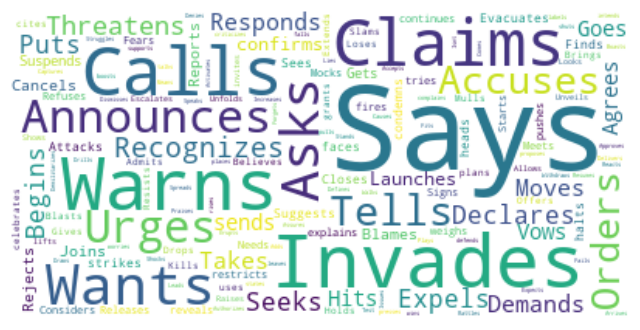

In [14]:
cluster_0_verbs_raw = " ".join(cluster_0_word_dict["VBZ"])
wordcloud = WordCloud(background_color="white").generate(cluster_0_verbs_raw)

# Display the generated image:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Lemmatization of Words

As one might notice from the word cloud above, some words appear mutliple times but with slightly different spelling. This isn't very useful and also distorts the data. Furthermore, there are some words that are just irrelevant. Due to these factors, the words in each group are lemmatized based on parts of speech and stop words are removed. Then, another word cloud of verbs is generated again for comparison. 

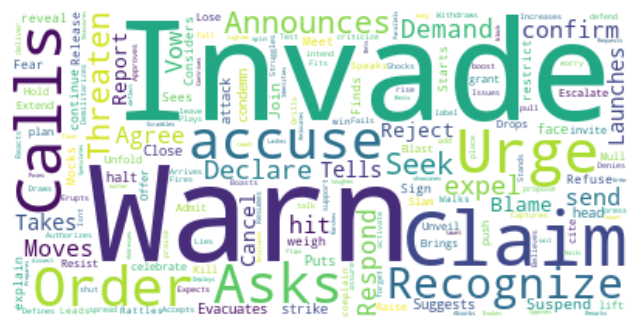

In [15]:
cluster_0_word_dict_lemmas = {}
for i in cluster_0_sentence.get_spans():
    letter = i.tag[0]
    if letter in ["N", "J", "V", "R"]:
        if letter == "J":
            letter = "a"
        else:
            letter = letter.lower()
        text = lemmatizer.lemmatize(i.text, pos = letter)
        if i.tag in cluster_0_word_dict_lemmas.keys():
            cluster_0_word_dict_lemmas[i.tag].append(text)
        else:
            cluster_0_word_dict_lemmas[i.tag] = [text]
            
cluster_0_verbs = " ".join(cluster_0_word_dict_lemmas["VBZ"])
stop_words = pd.read_csv("StopWords.csv", header=None)
stop_words = list(stop_words[0])

wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(cluster_0_verbs)

# Display the generated image:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Proper Nouns

Another word cloud example that might be helpful is the one made up out of proper nouns.

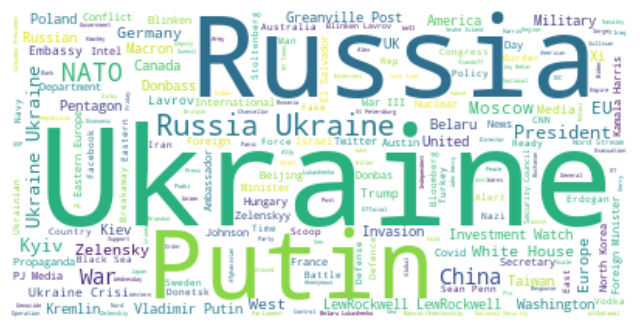

In [16]:
cluster_0_nouns = " ".join(cluster_0_word_dict_lemmas["NNP"])
wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(cluster_0_nouns)

# Display the generated image:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Monitoring the Cluster

If it has been decided to monitor a cluster, these prior processes can be repeated. However the new data needs to be attributed to clusters. To do this, the rough centers of the clusters are calculated, and new pieces of data are attributed to a cluster for which their embeddings are closest to. Below is an example of the following weeks worth of data and the rough centers.

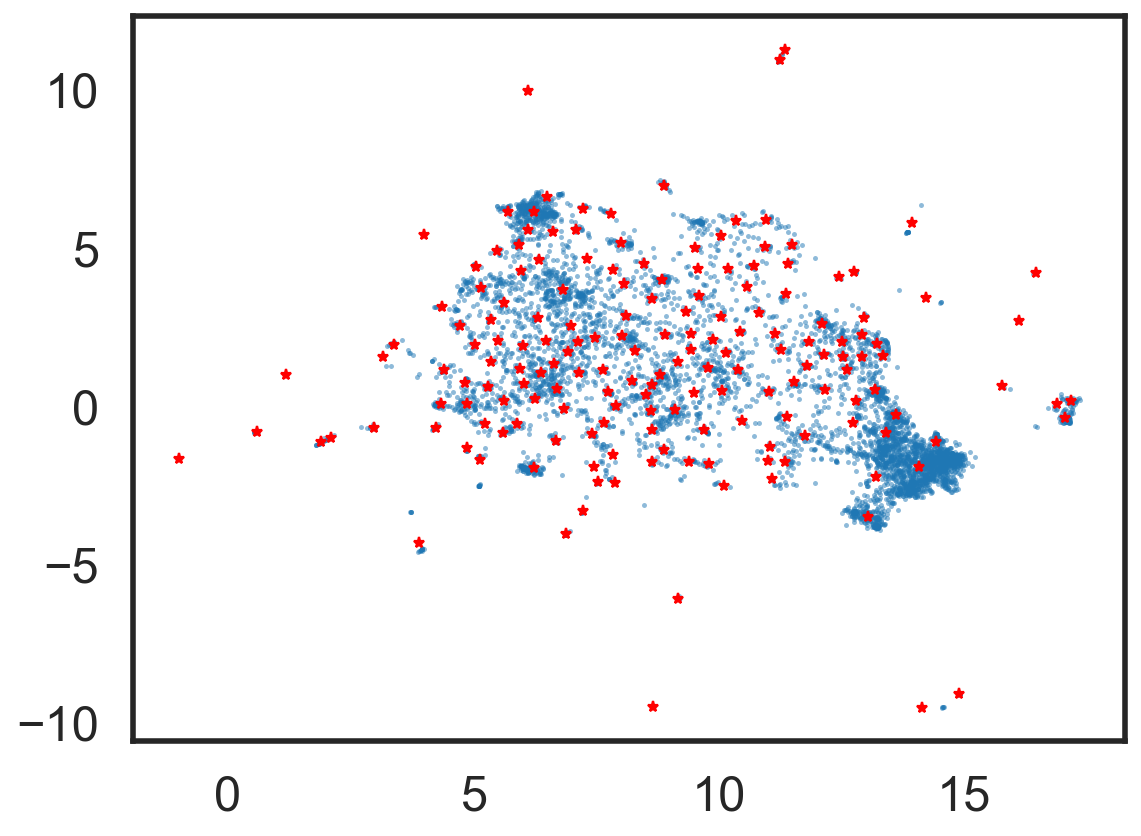

In [17]:
mar_8_ts = datetime.timestamp(datetime.strptime("03-08-2022", "%m-%d-%Y"))
week_after_data = base_data[base_data["seendate"] < mar_8_ts]
week_after_data = week_after_data[week_after_data["seendate"] >= mar_1_ts]

week_after_embeddings = embed(list(week_after_data["title"].dropna()))
week_after_reduced_embeddings = reducer.transform(week_after_embeddings)

plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(week_after_reduced_embeddings[:,0], week_after_reduced_embeddings[:,1], **plot_kwds)
plt.plot([i[0] for i in soft_cluster_centers], [i[1] for i in soft_cluster_centers], marker='*', ls='none', ms=5, c="red")

## Monitoring of a Cluster for a Month

Below is an example of doing the same as above, except for the whole month.

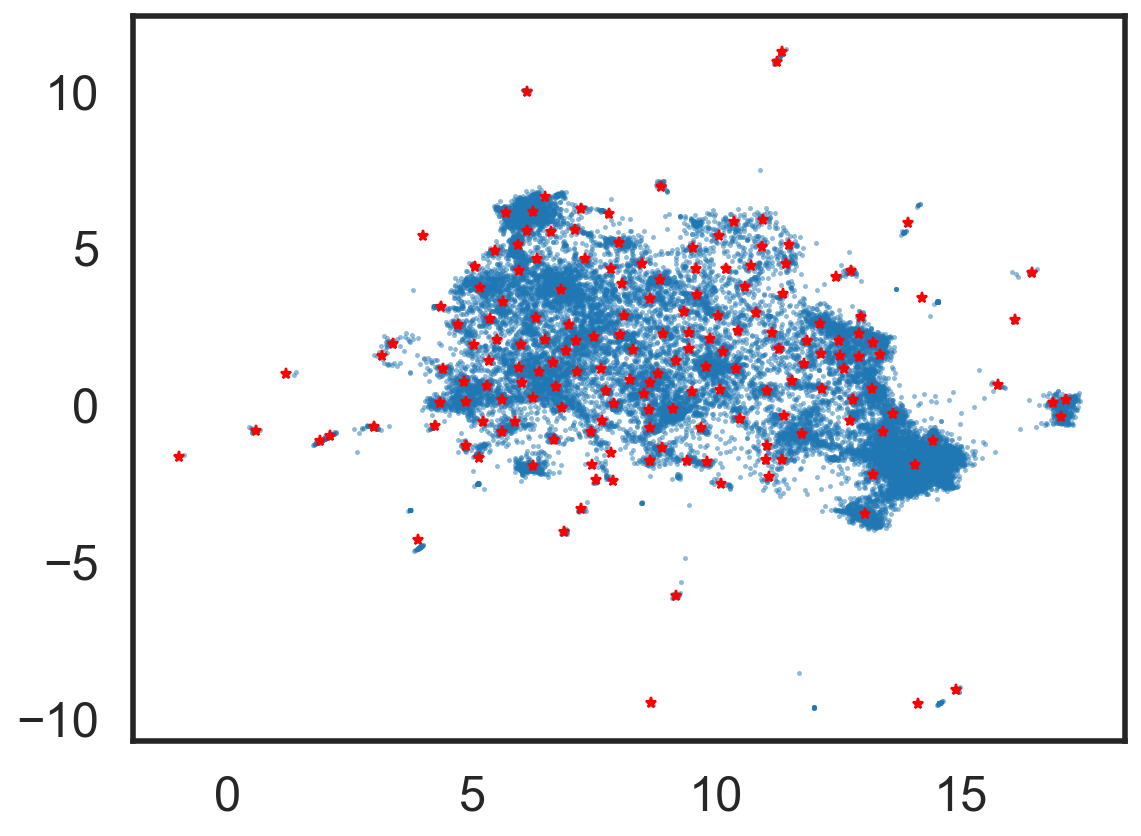

In [18]:
apr_1_ts = datetime.timestamp(datetime.strptime("04-01-2022", "%m-%d-%Y"))
month_after_data = base_data[base_data["seendate"] < apr_1_ts]
month_after_data = month_after_data[month_after_data["seendate"] >= mar_1_ts]

month_after_embeddings = embed(list(month_after_data["title"].dropna()))
month_after_reduced_embeddings = reducer.transform(month_after_embeddings)

plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(month_after_reduced_embeddings[:,0], month_after_reduced_embeddings[:,1], **plot_kwds)
plt.plot([i[0] for i in soft_cluster_centers], [i[1] for i in soft_cluster_centers], marker='*', ls='none', ms=5, c="red")

## Cluster Daily Growth for Baseline and Monitored Cluster

Below is a visualization of the baseline cluster daily growth and the monitored cluster. The baseline cluster is in blue, and the monitored cluster is in green.

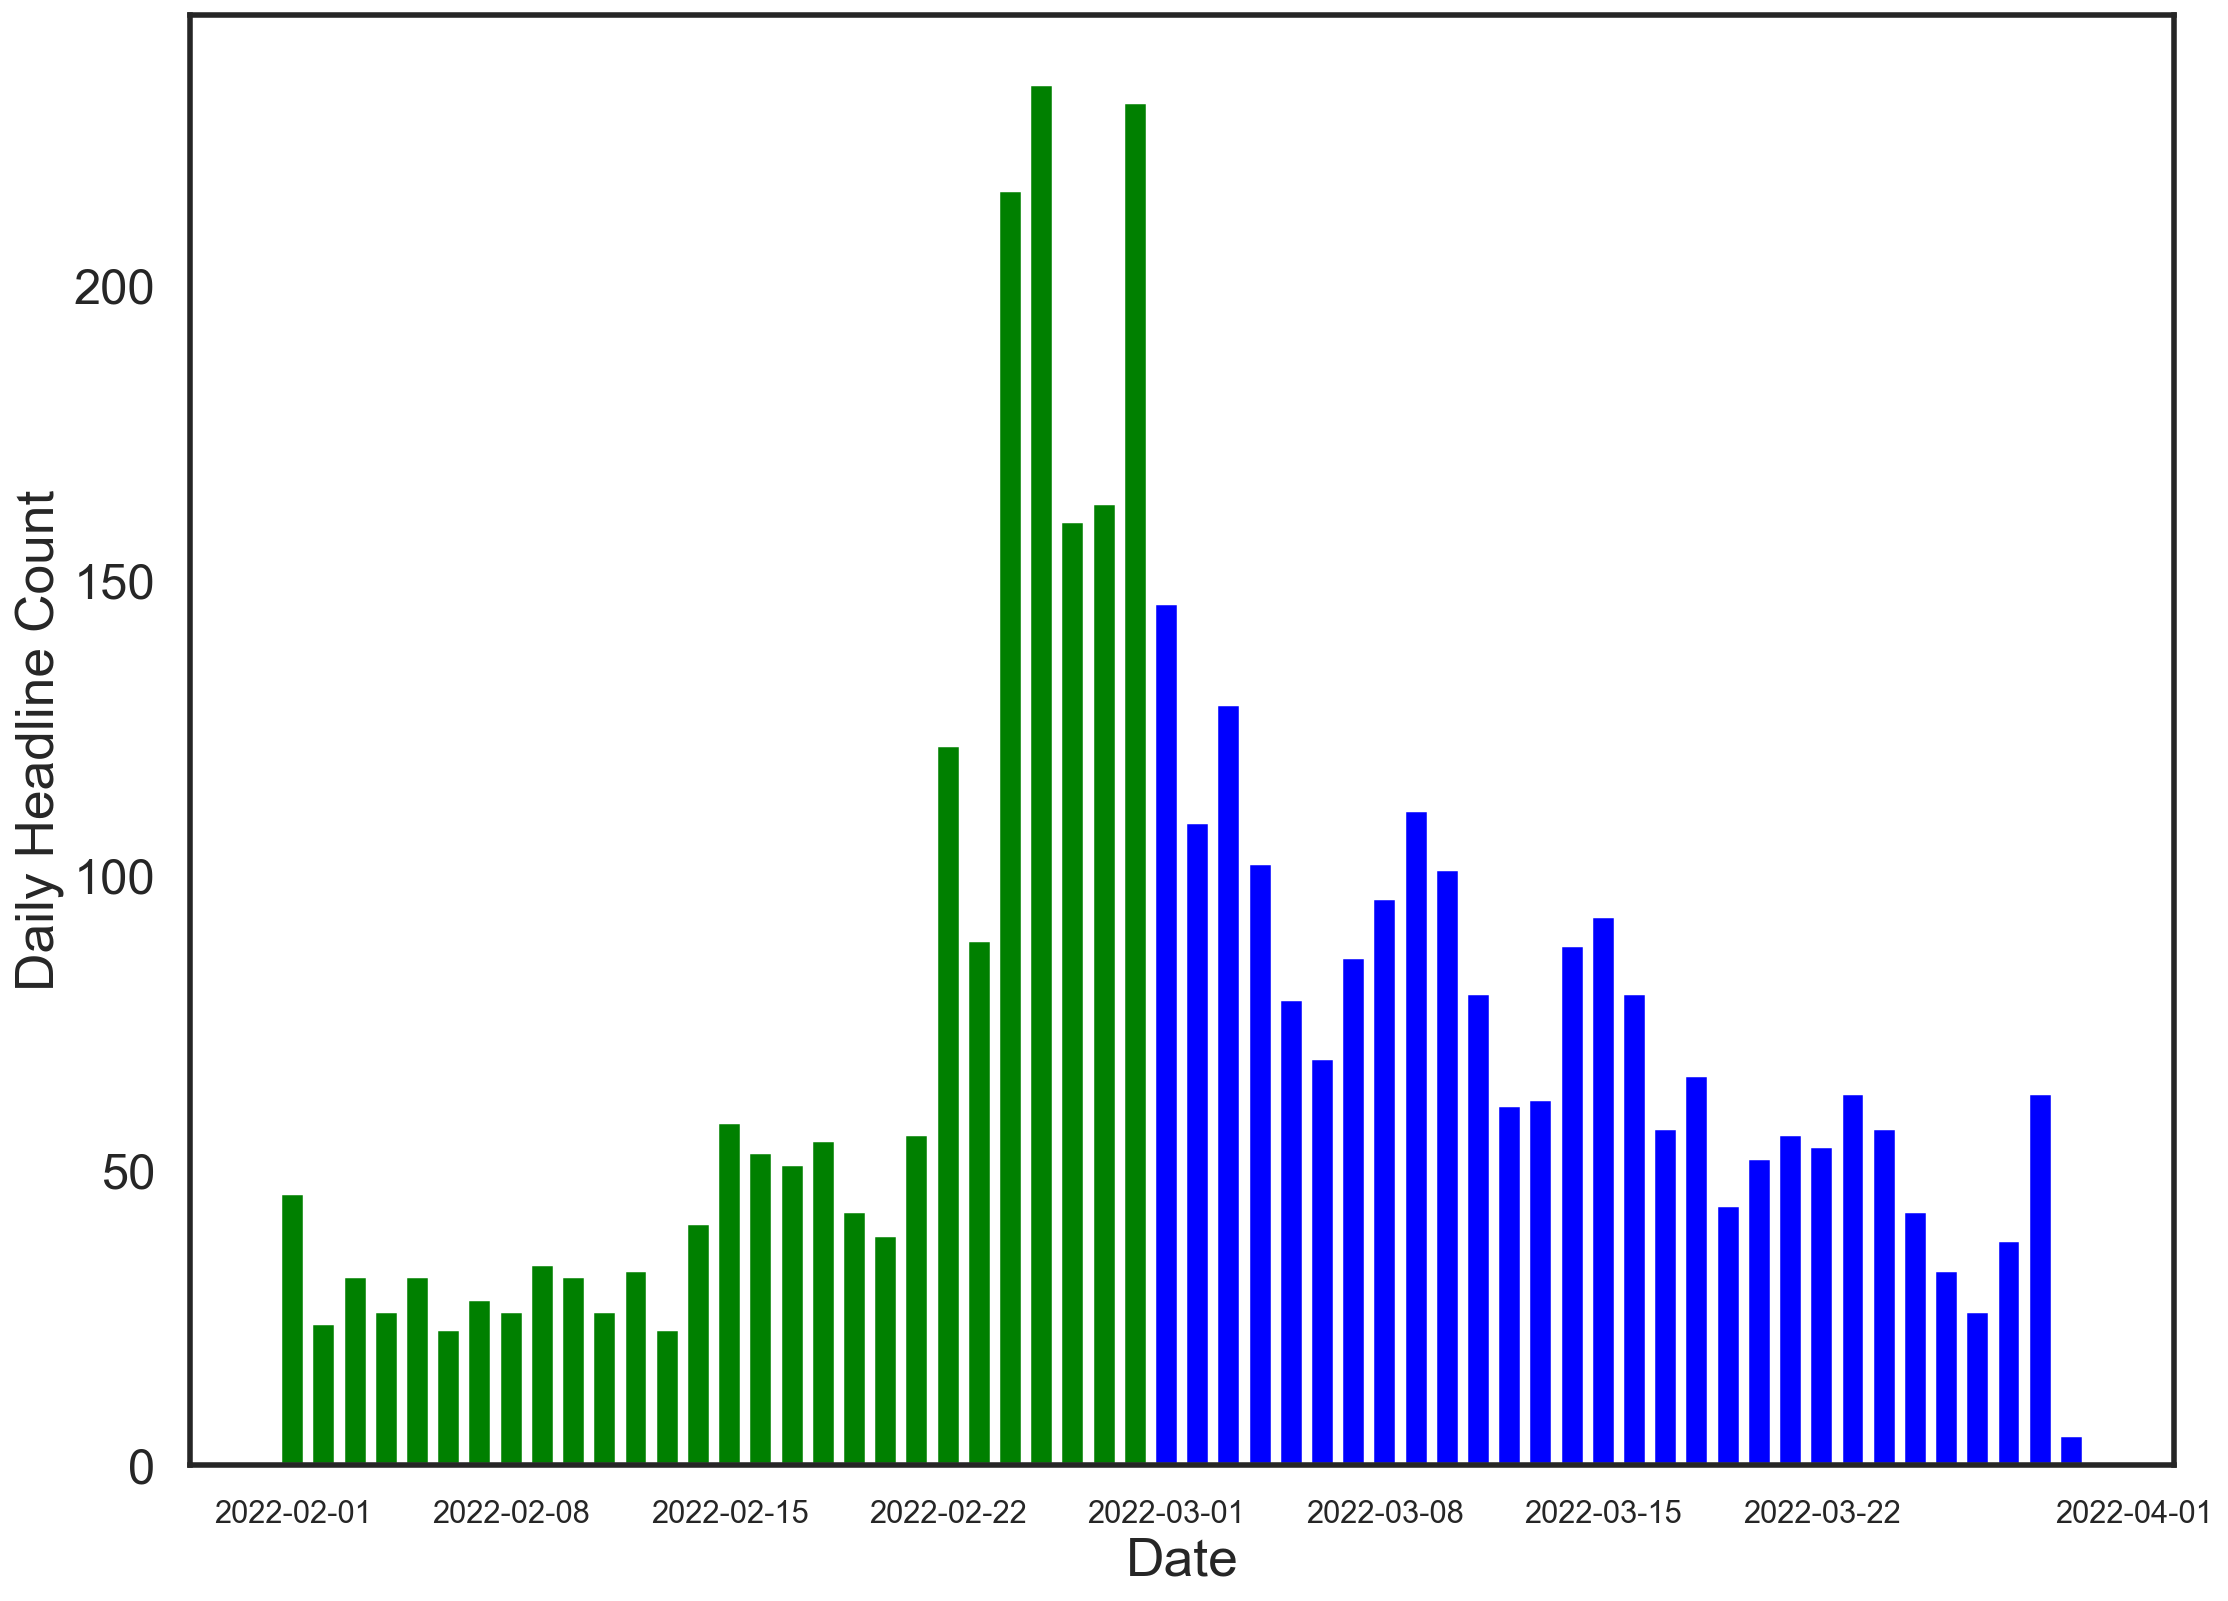

In [19]:
month_after_soft_cluster_indexes = [[] for i in range(0,len(soft_clusters[0]))]
month_after_soft_cluster_sizes = dict.fromkeys([i for i in range(0,len(soft_clusters[0]))],0)
for embedding in enumerate(month_after_reduced_embeddings):
    current_cluster = np.argmin([math.dist(embedding[1], i) for i in soft_cluster_centers])
    month_after_soft_cluster_indexes[current_cluster].append(embedding[0])
    month_after_soft_cluster_sizes[current_cluster] += 1
    
month_after_dates = [datetime.fromtimestamp(timestamp).strftime('%d-%m-%y') for timestamp in list(month_after_data.iloc[month_after_soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["seendate"])]

month_after_date_counts = [0 for date in range(0,len(np.unique(month_after_dates)))]
month_after_index = 0
month_after_day = month_after_dates[0]
for date in month_after_dates:
    if date != month_after_day:
        month_after_index += 1
        month_after_day = date
    month_after_date_counts[month_after_index] += 1
    
joined_date_counts = date_counts + month_after_date_counts
joined_dates = dates + month_after_dates

cluster_0_color = []
for i in sorted([datetime.strptime(i, '%d-%m-%y') for i in np.unique(joined_dates)]):
    if i < datetime.strptime("01-03-22", '%d-%m-%y'):
        cluster_0_color.append("green")
    else:
        cluster_0_color.append("blue")
        
plt.figure(figsize=(16, 12), dpi=160)
plt.bar(sorted([datetime.strptime(i, '%d-%m-%y') for i in np.unique(joined_dates)]), joined_date_counts, color=cluster_0_color)
plt.xticks(size="xx-small")
plt.xlabel('Date')
plt.ylabel('Daily Headline Count')
plt.show()

## Examples of Word Clouds for Another Cluster

In [20]:
cluster_string_2 = " ".join(list(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[2][0]]]["title"]))
cluster_sentence_2 = Sentence(cluster_string_2)
tagger.predict(cluster_sentence_2)
word_dict_2 = {}
for i in cluster_sentence_2.get_spans():
    if i.tag in word_dict_2.keys():
        word_dict_2[i.tag].append(i.text)
    else:
        word_dict_2[i.tag] = [i.text]

In [21]:
test_domains = list(set(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[0][0]]]["domain"]))

In [22]:
test_dict_2 = {}
for domain in test_domains:
    test_dict_2[domain] = 0
    for i in list(build_data.iloc[soft_cluster_indexes[sorted_soft_cluster_sizes[2][0]]]["domain"]):
        if domain == i:
            test_dict_2[domain] += 1

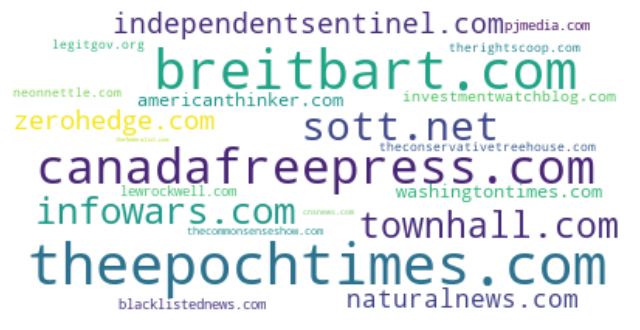

In [23]:
wordcloud = WordCloud(background_color="white").fit_words(test_dict_2)

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

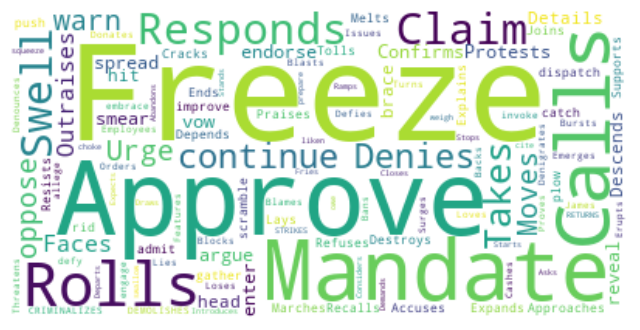

In [24]:
word_dict_lemmas_2 = {}
for i in cluster_sentence_2.get_spans():
    letter = i.tag[0]
    if letter in ["N", "J", "V", "R"]:
        if letter == "J":
            letter = "a"
        else:
            letter = letter.lower()
        text = lemmatizer.lemmatize(i.text, pos = letter)
        if i.tag in word_dict_lemmas_2.keys():
            word_dict_lemmas_2[i.tag].append(text)
        else:
            word_dict_lemmas_2[i.tag] = [text]
            
trial2 = " ".join(word_dict_lemmas_2["VBZ"])
stop_words = pd.read_csv("StopWords.csv", header=None)
stop_words = list(stop_words[0])

wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(trial2)

# Display the generated image:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

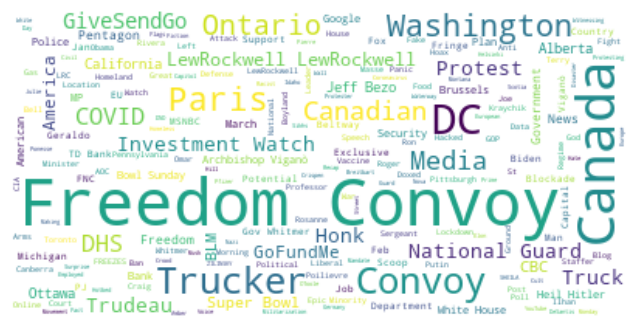

In [25]:
trial_2 = " ".join(word_dict_lemmas_2["NNP"])
stop_words = pd.read_csv("StopWords.csv", header=None)
stop_words = list(stop_words[0])

wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(trial_2)

# Display the generated image:
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Conclusion

For further context, please reference the whitepaper writeup.